## 1 Import all package 

In [1]:
import cv2
import csv
import os
import math
import random
import gc
import itertools
from torch.utils.data import Dataset
from natsort import natsorted
import torchvision
import matplotlib.image as mpimg

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url
from torch import optim

from PIL import Image
import matplotlib.pyplot as plt

## 2 Prepare data

### 2.1 Create data loader class

In [2]:
# Create Class

class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):  
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
         
        # List all images in folder and count them
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)
        
    def __len__(self):
        # Return the previously computed number of images
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
     
        # Use PIL for image loading
        image1 = Image.open(img_loc).convert("RGB")
        
        # Apply the transformations
        tensor_image = self.transform(image1)
        return tensor_image

### 2.2 Make data set and loading data

In [17]:
# Create data set and loader

# Traininng data
tmp_train_set =  torchvision.datasets.ImageFolder(
    "./Dataset/train", 
    transform=transforms.ToTensor()
)

tmp_train_loader = torch.utils.data.DataLoader(
    tmp_train_set,
    batch_size=32,
    shuffle=True,
    #num_workers=2
)


# test data
test_set = torchvision.datasets.ImageFolder(
    "./Dataset/test", 
    transform=transforms.ToTensor()
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=32, # Forward pass only so batch size can be larger
    shuffle=False,
    #num_workers=0
)

# All class type
classes = ("benign", "malignant")

### 2.3 Split train data for train and validation

In [4]:
# Split train data set and make a single 64 batch size

train_size = 0.8 * len(tmp_train_set)
validation_size = len(tmp_train_set) - train_size
train_set, validation_set = torch.utils.data.random_split(tmp_train_set, [int(train_size), int(validation_size)])

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = 32,
    shuffle = True,
    num_workers = 2
)
val_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size = 32,
    shuffle = True,
    num_workers = 2
)

### 2.4 Check data loader

In [5]:
# Check data loader
print(next(iter(train_set[0])).shape) 
print(next(iter(train_set[0])).shape) 

# Checke train set and validation set
print(len(train_set))
print(len(validation_set))

torch.Size([3, 300, 300])
torch.Size([3, 300, 300])
7684
1921


### 2.5 Test load data

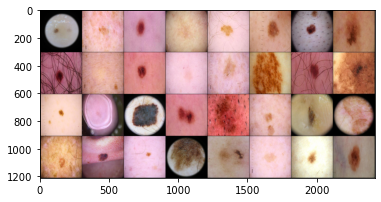

labels ['malignant', 'benign', 'benign', 'malignant', 'benign', 'malignant', 'malignant', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'malignant', 'benign', 'malignant', 'benign', 'malignant', 'malignant', 'benign', 'malignant', 'benign', 'malignant', 'malignant', 'benign', 'benign', 'malignant']


In [6]:
# Show example

def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
    
# get some random training images using the data loader
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images and labels
timshow(torchvision.utils.make_grid(images))

print(f"labels {[classes[labels[i]] for i in range(32)]}")

## 3 Create Models

### 3.1 CNN model

In [7]:
# Create CNN model

CNN_model = nn.Sequential(
    nn.Conv2d(3,64,(3,3),1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,stride=2),

    nn.Conv2d(64,256,(3,3),stride=1),
    nn.ReLU(),
    nn.MaxPool2d(3,stride=3),
    
    nn.Conv2d(256,512,(2,2),stride=1),
    nn.ReLU(),
    nn.MaxPool2d(3,stride=3),
    
    nn.Flatten(),
    nn.Linear(512*16*16,2048),
    nn.ReLU(),
    nn.Linear(2048,2)
)


### 3.2 Alex model

In [8]:
# Loading Alex CNN model

Alex_model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(11, 11), stride=4, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=False),

    nn.Conv2d(64, 192, kernel_size=(5, 5), stride=1, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=False),
    
    nn.Conv2d(192, 384, kernel_size=(3, 3), stride=1, padding=1),
    nn.ReLU(inplace=True),
    
    nn.Conv2d(384, 256, kernel_size=(3, 3), stride=1, padding=1),
    nn.ReLU(inplace=True),
    
    nn.Conv2d(256, 256, kernel_size=(3, 3), stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=False),
    
    nn.Flatten(),
    nn.Linear(in_features=256*8*8, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(4096,2)
)


### 3.3 Early stop function

In [8]:
# Record and save the best point of training to prevent over-fitting of training

class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    # Determine the pros and cons of parameters
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    # Store the optimal parameters in this function
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

### 3.4 Draw line graph Function

In [9]:
def lineGraphWithMidLine(resultsPath, savePath, nepochs, patience):
    results_path = resultsPath
    data = torch.load(results_path)
    statsrec = data["stats"]
    i = 0
    for c in statsrec[1][0:-1]:
        i += 1
        if c == 0:
            break 
    fig, ax1 = plt.subplots()
    minposs =  i - patience - 1
    list1 = statsrec[0][0:i-1]
    list2 = statsrec[2][0:i-1]
    list3 = statsrec[1][0:i-1]
    list4 = statsrec[3][0:i-1]
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    plt.plot(list1, 'r', label = 'training loss', )
    plt.plot(list2, 'g', label = 'test loss' )
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and test loss, and test accuracy')
    ax2=ax1.twinx()
    ax2.plot(list3, 'm', label = 'training accuracy')
    ax2.plot(list4, 'b', label = 'test accuracy')
    ax2.set_ylabel('accuracy')
    plt.legend(loc='upper right')
    fig.savefig(savePath)
    plt.show()

## 4 Training CNN model

### 4.1 SGD Training

### 4.1.1 SGD algorithm

In [11]:
# Calculate the loss rate and accuracy of validation set

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def stats(loader, model):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)      
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            
    return running_loss/n, correct/total 

In [11]:
nepochs = 500
patience = 6

results_path = "./Models/SGD_MyCNN.pt"

statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_model.parameters(), lr=0.001, momentum=0.9)

early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range (nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches

    for data in train_loader:
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = CNN_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(val_loader, CNN_model)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
        
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validate loss: {ltst: .3f} validate accuracy: {atst: .1%}")
    early_stopping(ltst, CNN_model)     
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# save network parameters, losses and accuracy
torch.save({"state_dict": CNN_model.state_dict(), "stats": statsrec}, results_path)

C:\Users\73539\AppData\Roaming\Python\Python38\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0 training loss:  0.581 training accuracy:  70.3%  validate loss:  0.462 validate accuracy:  76.2%
Validation loss decreased (inf --> 0.462284).  Saving model ...
epoch: 1 training loss:  0.430 training accuracy:  80.5%  validate loss:  0.395 validate accuracy:  80.3%
Validation loss decreased (0.462284 --> 0.394969).  Saving model ...
epoch: 2 training loss:  0.339 training accuracy:  85.0%  validate loss:  0.324 validate accuracy:  85.3%
Validation loss decreased (0.394969 --> 0.323935).  Saving model ...
epoch: 3 training loss:  0.308 training accuracy:  86.6%  validate loss:  0.311 validate accuracy:  86.5%
Validation loss decreased (0.323935 --> 0.311063).  Saving model ...
epoch: 4 training loss:  0.290 training accuracy:  87.7%  validate loss:  0.317 validate accuracy:  87.2%
EarlyStopping counter: 1 out of 6
epoch: 5 training loss:  0.273 training accuracy:  88.3%  validate loss:  0.271 validate accuracy:  88.0%
Validation loss decreased (0.311063 --> 0.271487).  Saving 

### 4.1.2 Loss and accuracy rate chart for SGD

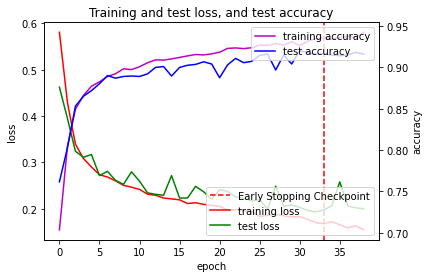

In [12]:
lineGraphWithMidLine("./Models/SGD_MyCNN.pt", "./Results/SGDResult.svg", 500, 6)

### 4.2 Adam Training

### 4.2.1 Adam algorithm

In [11]:
nepochs = 500
patience = 6

results_path = "./Models/Adam_MyCNN.pt"

statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range (nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches

    for data in train_loader:
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = CNN_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(val_loader, CNN_model)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
        
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validate loss: {ltst: .3f} validate accuracy: {atst: .1%}")
    early_stopping(ltst, CNN_model)     
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# save network parameters, losses and accuracy
torch.save({"state_dict": CNN_model.state_dict(), "stats": statsrec}, results_path)

C:\Users\73539\AppData\Roaming\Python\Python38\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0 training loss:  0.492 training accuracy:  82.5%  validate loss:  0.269 validate accuracy:  88.6%
Validation loss decreased (inf --> 0.268941).  Saving model ...
epoch: 1 training loss:  0.283 training accuracy:  88.3%  validate loss:  0.256 validate accuracy:  89.8%
Validation loss decreased (0.268941 --> 0.256439).  Saving model ...
epoch: 2 training loss:  0.270 training accuracy:  88.9%  validate loss:  0.278 validate accuracy:  88.0%
EarlyStopping counter: 1 out of 6
epoch: 3 training loss:  0.238 training accuracy:  90.3%  validate loss:  0.254 validate accuracy:  90.0%
Validation loss decreased (0.256439 --> 0.253500).  Saving model ...
epoch: 4 training loss:  0.228 training accuracy:  90.4%  validate loss:  0.223 validate accuracy:  90.7%
Validation loss decreased (0.253500 --> 0.222776).  Saving model ...
epoch: 5 training loss:  0.215 training accuracy:  91.6%  validate loss:  0.227 validate accuracy:  91.2%
EarlyStopping counter: 1 out of 6
epoch: 6 training loss:  

### 4.2.2 Loss and accuracy rate chart for Adam

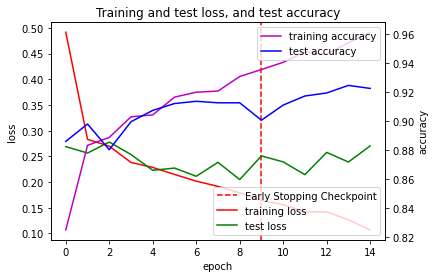

In [14]:
lineGraphWithMidLine("./Models/Adam_MyCNN.pt", "./Results/AdamResult.svg",500, 6)

### 4.3 Adam Training with 128 Batch Size

### 4.3.1 Increase batch size to 128

In [14]:
train_loader_128 = torch.utils.data.DataLoader(
    train_set,
    batch_size = 128,
    shuffle = True,
    num_workers = 2
)
val_loader_128 = torch.utils.data.DataLoader(
    validation_set,
    batch_size = 128,
    shuffle = True,
    num_workers = 2
)

### 4.3.2  Adam algorithm retraining(batch size 128)

In [18]:
%reset out

gc.collect()

nepochs = 500
patience = 6

results_path = "./Models/Adam128_MyCNN.pt"

statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range (nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches

    for data in train_loader_128:
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = CNN_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(val_loader_128, CNN_model)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
        
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validate loss: {ltst: .3f} validate accuracy: {atst: .1%}")
    early_stopping(ltst, CNN_model)     
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# save network parameters, losses and accuracy
torch.save({"state_dict": CNN_model.state_dict(), "stats": statsrec}, results_path)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (0 entries)
epoch: 0 training loss:  0.374 training accuracy:  83.8%  validate loss:  0.329 validate accuracy:  87.2%
Validation loss decreased (inf --> 0.329069).  Saving model ...
epoch: 1 training loss:  0.278 training accuracy:  87.7%  validate loss:  0.276 validate accuracy:  86.2%
Validation loss decreased (0.329069 --> 0.276296).  Saving model ...
epoch: 2 training loss:  0.260 training accuracy:  89.0%  validate loss:  0.276 validate accuracy:  86.6%
Validation loss decreased (0.276296 --> 0.275916).  Saving model ...
epoch: 3 training loss:  0.246 training accuracy:  90.0%  validate loss:  0.273 validate accuracy:  88.0%
Validation loss decreased (0.275916 --> 0.272668).  Saving model ...
epoch: 4 training loss:  0.221 training accuracy:  91.0%  validate loss:  0.262 validate accuracy:  89.4%
Validation loss decreased (0.272668 --> 0.261877).  Saving model ...
epoch: 5 training loss:  0.214 t

### 4.3.3 Loss and accuracy rate chart for Adam(batch size 128)

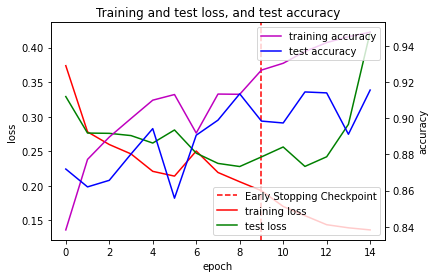

In [19]:
lineGraphWithMidLine("./Models/Adam128_MyCNN.pt", "./Results/Adam128Result.svg", 500, 6)

### 4.4 SGD Training with AlexNet

### 4.4.1 Using GPU

In [10]:
import torch
print(torch.__version__)
print(torch.cuda_version)
print(torch.cuda.is_available())

1.9.0+cu111
11.1
True


### 4.4.1 Computing Validate Loss Function with GPU

In [11]:
# Calculate the loss rate and accuracy of validation set

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def stats_GPU(loader, model):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    
    model = model.to(device)
    
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)      
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            
    return running_loss/n, correct/total 

### 4.4.3 Training for Alex model

In [12]:
nepochs = 500
patience = 6

results_path = "./Models/SGD_Alex.pt"

statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
Alex_model = Alex_model.to(device)
    
optimizer = optim.SGD(Alex_model.parameters(), lr=0.001, momentum=0.9)

early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range (nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches

    for data in train_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = Alex_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats_GPU(val_loader, Alex_model)
    ltst = ltst.cpu()
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
        
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validate loss: {ltst: .3f} validate accuracy: {atst: .1%}")
    early_stopping(ltst, Alex_model)     
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# save network parameters, losses and accuracy
torch.save({"state_dict": Alex_model.state_dict(), "stats": statsrec}, results_path)

C:\Users\73539\AppData\Roaming\Python\Python38\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0 training loss:  0.692 training accuracy:  51.8%  validate loss:  0.691 validate accuracy:  51.9%
Validation loss decreased (inf --> 0.691118).  Saving model ...
epoch: 1 training loss:  0.691 training accuracy:  52.1%  validate loss:  0.691 validate accuracy:  51.9%
EarlyStopping counter: 1 out of 6
epoch: 2 training loss:  0.689 training accuracy:  52.1%  validate loss:  0.688 validate accuracy:  51.9%
Validation loss decreased (0.691118 --> 0.688005).  Saving model ...
epoch: 3 training loss:  0.683 training accuracy:  52.3%  validate loss:  0.676 validate accuracy:  52.1%
Validation loss decreased (0.688005 --> 0.676300).  Saving model ...
epoch: 4 training loss:  0.657 training accuracy:  58.6%  validate loss:  0.661 validate accuracy:  58.0%
Validation loss decreased (0.676300 --> 0.660527).  Saving model ...
epoch: 5 training loss:  0.585 training accuracy:  70.4%  validate loss:  0.560 validate accuracy:  67.3%
Validation loss decreased (0.660527 --> 0.560158).  Saving 

epoch: 53 training loss:  0.192 training accuracy:  92.3%  validate loss:  0.191 validate accuracy:  91.8%
EarlyStopping counter: 1 out of 6
epoch: 54 training loss:  0.192 training accuracy:  92.3%  validate loss:  0.184 validate accuracy:  92.3%
EarlyStopping counter: 2 out of 6
epoch: 55 training loss:  0.186 training accuracy:  92.6%  validate loss:  0.197 validate accuracy:  91.8%
EarlyStopping counter: 3 out of 6
epoch: 56 training loss:  0.186 training accuracy:  92.4%  validate loss:  0.190 validate accuracy:  92.4%
EarlyStopping counter: 4 out of 6
epoch: 57 training loss:  0.186 training accuracy:  92.5%  validate loss:  0.180 validate accuracy:  92.2%
Validation loss decreased (0.181370 --> 0.179788).  Saving model ...
epoch: 58 training loss:  0.185 training accuracy:  92.7%  validate loss:  0.191 validate accuracy:  91.9%
EarlyStopping counter: 1 out of 6
epoch: 59 training loss:  0.181 training accuracy:  92.7%  validate loss:  0.186 validate accuracy:  92.3%
EarlyStoppin

### 4.4.4 Loss and accuracy rate chart for SGD(Alex model)

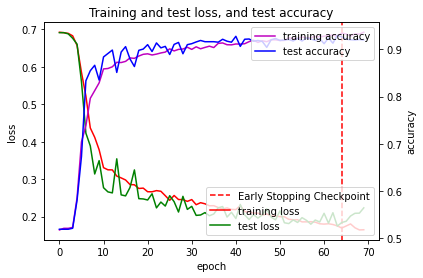

In [13]:
lineGraphWithMidLine("./Models/SGD_Alex.pt", "./Results/SGDAlexResult.svg", 500, 6)

### 4.5 Confusion matrices

In [14]:
# Computing confusion matrix

def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

In [15]:
# Draw confusion matrix

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #print(cm)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    plt.axis("equal")
    
    # Get the current axis  
    ax = plt.gca()  
    
    #Get the maximum and minimum values of the X-axis
    left, right = plt.xlim()  
    ax.spines['left'].set_position(('data', left))
    ax.spines['right'].set_position(('data', right))
    for edge_i in ['top', 'bottom', 'right', 'left']:
        ax.spines[edge_i].set_edgecolor("white")


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{:.2f}'.format(cm[i, j]) if normalize else int(cm[i, j])
        plt.text(i, j, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if float(num) > float(thresh) else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Normalized confusion matrix


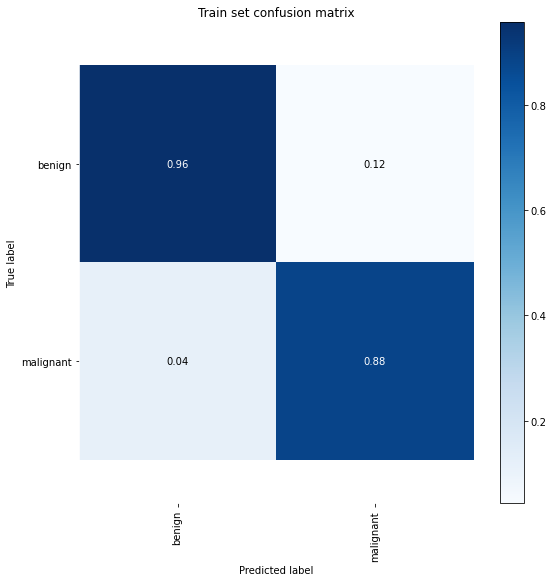

Normalized confusion matrix


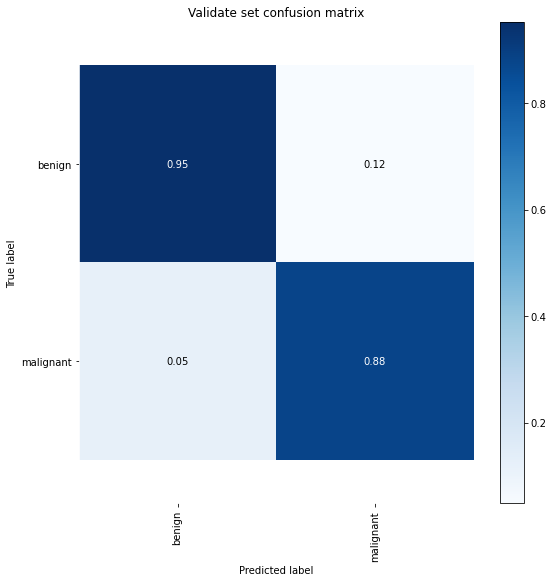

In [17]:
def drawMatrix(dataLoader, title1):
    conf_matrix = torch.zeros(2, 2)
    classesType = ("benign", "malignant")
    
    for data in dataLoader:
        batch_images, batch_labels = data
        # print(batch_labels)
        with torch.no_grad():
            if torch.cuda.is_available():
                batch_images, batch_labels = batch_images.cuda(),batch_labels.cuda()
            
        outputs = Alex_model(batch_images)
        prediction = torch.max(outputs, 1)[1]
        conf_matrix = confusion_matrix(prediction, labels=batch_labels, conf_matrix=conf_matrix)
    plot_confusion_matrix(conf_matrix.numpy(), classes=classesType, normalize=True, title=title1)

# Confusion matrix for train set
drawMatrix(train_loader, 'Train set confusion matrix')
# Confusion matrix for validate set
drawMatrix(val_loader, 'Validate set confusion matrix')

## 5 Test Net

###  5.1 Test Function

In [20]:
def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)  

In [21]:
def accuracyTest(ModelPath, Model):
    modelData = torch.load(ModelPath)
    Model.load_state_dict(modelData["state_dict"])
    
    cnfm = np.zeros((2,2),dtype=int)
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = Model(images)
            
            _, predicted = torch.max(outputs, 1)   
            
            for i in range(labels.size(0)):
                cnfm[labels[i].item(),predicted[i].item()] += 1
                
    print(f"Accuracy: {accuracy(cnfm) :.1%}")
    r = recalls(cnfm)
    p = precisions(cnfm)
    for i in range(2):
        print(f"Class {classes[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")

### 5.2 Test Different Net

### 5.2.1 SGD data test

In [23]:
accuracyTest("./Models/SGD_MyCNN.pt",CNN_model)

Accuracy: 91.2%
Class 0 : Precision 90.9%  Recall 91.6%
Class 1 : Precision 91.5%  Recall 90.8%


### 5.2.2 adam data test

In [24]:
accuracyTest("./Models/Adam_MyCNN.pt",CNN_model)

Accuracy: 91.2%
Class 0 : Precision 89.3%  Recall 93.6%
Class 1 : Precision 93.3%  Recall 88.8%


### 5.2.3 Adam 128 data test

In [25]:
accuracyTest("./Models/Adam128_MyCNN.pt",CNN_model)

Accuracy: 90.3%
Class 0 : Precision 89.0%  Recall 92.0%
Class 1 : Precision 91.7%  Recall 88.6%


### 5.2.4 Alex model data test

In [26]:
accuracyTest('./Models/SGD_Alex.pt',Alex_model)

Accuracy: 89.8%
Class 0 : Precision 92.0%  Recall 87.2%
Class 1 : Precision 87.8%  Recall 92.4%
